# Assignment: Predicting inflation in Poland in May 2023 

**Short summary:** As accepted, inflation in Poland will continue to decrease and for May it will have 13,63%. As the result of published inflation that has 13% we can say that the prediction accuracy is approximately -4.85%. The negative sign indicates that the prediction overestimated the actual value.

**Prediction Accuracy = ((Actual Value - Predicted Value) / Actual Value) * 100**


**Why ARIMA model?**
I have used the ARIMA (Auto Regressive Integrated Moving Average) model for forecasting inflation in Poland because it is a suitable model for capturing patterns in a non-seasonal time series like inflation.
The ARIMA model incorporates both autoregressive (AR) and moving average (MA) components, along with differencing (I) to make the series stationary. 

**What does the ARIMA model contain?** The ARIMA model combines the following components: 

Autoregressive (AR): This component considers the relationship between an observation and a specific number of lagged observations. The parameter 'p' determines the lag order, or the number of lag observations included in the model. Moving Average (MA): This component considers the relationship between the residual error and a specific number of lagged forecast errors. The parameter 'q' represents the number of lagged errors included in the model. Differencing (I): This component is used to make the time series stationary by taking differences between consecutive observations. The parameter 'd' represents the number of times the raw observations are differenced. Is our dataset stationary? Before applying the ARIMA model, it is essential to check if the dataset is stationary. Stationarity means that the statistical properties of the time series remain constant over time. If the dataset is not stationary, differencing is required to achieve stationarity. How to determine the values of p, d, and q? The values of the parameters p, d, and q are determined through analysis and evaluation of the dataset. Techniques such as autocorrelation function (ACF) and partial autocorrelation function (PACF) plots can help in identifying the appropriate values. These plots provide insights into the correlation between observations and lagged observations, which guide the selection of the parameters. What are the benefits of using ARIMA? ARIMA models are widely used for time series forecasting because they can capture dependencies and patterns present in the historical data. By incorporating the lagged observations and forecast errors, ARIMA models provide a framework for understanding the dynamics of the time series and making accurate future predictions. 

To sum up, the ARIMA model is chosen for its ability to model non-seasonal time series like inflation in Poland. By considering the autoregressive, moving average, and differencing components, the ARIMA model can capture the underlying patterns and dependencies in the data, enabling accurate forecasting of future inflation rates.


# 1 Loading and Processing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data of CPI 
dataset = pd.read_excel('poland_inflation_data.xlsx')
dataset.tail() #check ending of the table

,Year,1,2,3,4,5,6,7,8,9,10,11,12
22,2019,0.6,1.3,1.7,2.1,2.2,2.3,2.5,2.6,2.4,2.3,2.4,3.0
23,2020,3.8,4.1,3.9,2.9,3.4,3.8,3.7,3.7,3.8,3.8,3.7,3.4
24,2021,3.6,3.6,4.4,5.1,4.6,4.1,4.7,5.0,5.6,6.4,7.4,8.0
25,2022,8.7,8.1,10.2,11.4,12.8,14.2,14.2,14.8,15.7,16.4,16.1,15.3
26,2023,15.9,17.2,15.2,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#unpivot from wide to long format
dataset = dataset.iloc[1:].melt(id_vars=['Year'], var_name='Month', value_name='Rate')
dataset.tail()

,Year,Month,Rate
307,2019,12,3.0
308,2020,12,3.4
309,2021,12,8.0
310,2022,12,15.3
311,2023,12,NaN


In [4]:
# add new date column and assign last day of month
from pandas.tseries.offsets import MonthEnd
dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)

# order ascending data values 
dataset = dataset.sort_values(by=['Date'])
dataset.head()

,Year,Month,Rate,Date
0,1998,1,13.6,1998-01-31
26,1998,2,14.3,1998-02-28
52,1998,3,14.0,1998-03-31
78,1998,4,13.6,1998-04-30
104,1998,5,13.5,1998-05-31


In [5]:
#checking the dataset
dataset

,Year,Month,Rate,Date
0,1998,1,13.6,1998-01-31
26,1998,2,14.3,1998-02-28
52,1998,3,14.0,1998-03-31
78,1998,4,13.6,1998-04-30
104,1998,5,13.5,1998-05-31
...,...,...,...,...
207,2023,8,NaN,2023-08-31
233,2023,9,NaN,2023-09-30
259,2023,10,NaN,2023-10-31
285,2023,11,NaN,2023-11-30


In [6]:
# select needed columns
df = dataset[['Date', 'Rate']]

# set date column as index
df.set_index('Date', inplace=True)

# drop NaN rows
df.dropna(subset=['Rate'], inplace=True)
df.tail()

,Rate
Date,
2022-12-31,15.3
2023-01-31,15.9
2023-02-28,17.2
2023-03-31,15.2
2023-04-30,14.0


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,304.0,3.845724,3.861879,-1.3,1.2,3.15,4.5,17.2


# 2 Visualizing Time Series

Lets check our full picture of CPI with graphs.

<Axes: xlabel='Date'>

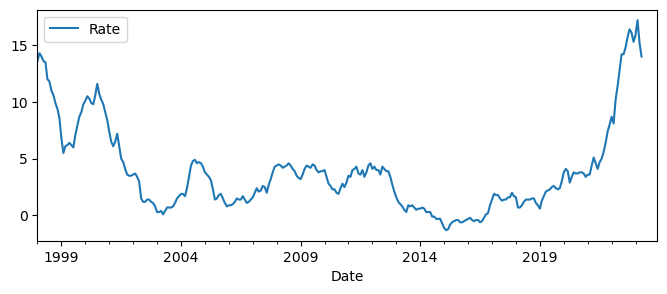

In [8]:
# time series of inflation percentage
dataset.plot(x='Date', y='Rate', figsize=(8,3))

**Short summary** : overall, our chart shows that inflation has been rising sharply over the past two years, but we are seeing a drop in inflation in the first months of 2023.

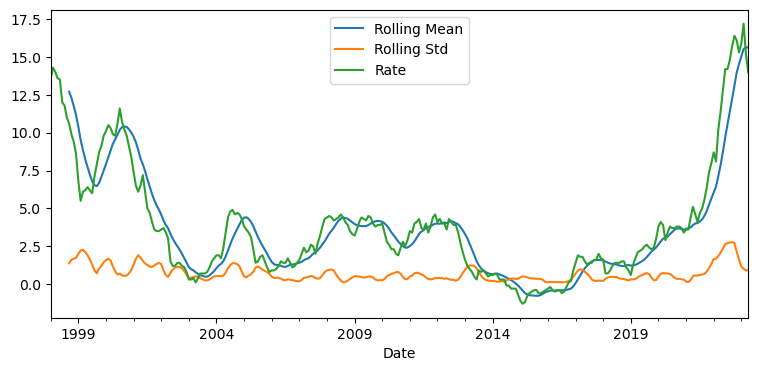

In [9]:
# more time series of inflation percentage
time_series = df['Rate'] # Extract the rate data as a time series 
time_series.rolling(window=9).mean().plot(label='Rolling Mean') # Calculate and plot the rolling mean with a window size of 12
time_series.rolling(window=9).std().plot(label='Rolling Std') # Calculate and plot the rolling standard deviation with a window size of 12
time_series.plot(figsize=(9,4)) # Plot the original time series
plt.legend() # Display the legend for the plot
plt.show() # Show the final plot

# 3 Identifying if the Data is Stationary

To determine if the inflation series is stationary, we can use the Augmented Dickey Fuller (ADF) test. The ADF test helps us determine the nature of the data by testing the null hypothesis that the data is non-stationary. If the calculated p-value is less than the significance level (usually 0.05), we reject the null hypothesis and conclude that the series is stationary.

In practical terms, if the p-value is greater than 0.05, indicating non-stationarity, we will need to perform differencing to make the series stationary. Conversely, if the p-value is less than or equal to 0.05, we can consider the series as stationary without the need for differencing (d=0).

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
# ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('1) ADF: ', result[0])
    print('2) P-value: ', result[1])
    print('3) Num of Lags: ', result[2])
    print('4) Num of Observations: ', result[3])
    print('5) Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)
        
    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0)')
    else:
        print('\nWeak evidence against null hypothesis')

# run function
adf_test(df['Rate'])

1) ADF:  -0.9404018484880696
2) P-value:  0.7743766114712923
3) Num of Lags:  13
4) Num of Observations:  290
5) Critial Values:
	 1% :  -3.453102162983312
	 5% :  -2.871558538275452
	 10% :  -2.5721082282996433

Weak evidence against null hypothesis


<code>P-value</code> is bigger than 0.05 (actually is 0.77) which means our data series is non-stationary. For this purpose we will use methodology of determining <code>d</code> in the next step.

# 4 Differencing - Determining *d* Order

Using <code>pmdarima</code> package we can easily find value of <code>d</code> term with different tests. 

In [12]:
from pmdarima.arima.utils import ndiffs

In [13]:
# finding differencing value
from pmdarima.arima.utils import ndiffs
print(ndiffs(df['Rate'], test='adf'))
print(ndiffs(df['Rate'], test='kpss'))
print(ndiffs(df['Rate'], test='pp'))

1
2
1


Based on the results of the differencing tests using the <code>ADF</code>, <code>KPSS</code>, and <code>PP</code> tests, the recommended values for the parameter <code>d</code> (the number of times the raw observations should be differenced) are as follows:

<code>ADF test</code>: The ADF test suggests a differencing value of 1. This means taking the first difference of the series (i.e., subtracting each observation from its previous observation) may be sufficient to make the series stationary.

<code>KPSS test</code>: The KPSS test suggests a differencing value of 2. This indicates that taking the second difference of the series may be necessary to achieve stationarity.

<code>PP test</code>: The Phillips-Perron (PP) test suggests a differencing value of 1. This aligns with the recommendation from the ADF test, indicating that the first difference could be enough to achieve stationarity.

In our case, considering the results of these tests, a reasonable choice for <code>'d'</code> would be either 1 or 2, but we will decide later.

### ACF + PACF - finding *p* and *q* 

*Autocorrelation and partial autocorrelation provide information about the relationship between observations in a time series. Autocorrelation examines the dependence of a term on its previous values, while partial autocorrelation measures the correlation between observations while considering the influence of other observations.*

*By analyzing the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots, we can determine the optimal number of autoregressive (AR) and moving average (MA) terms for the ARIMA model. ACF helps identify the appropriate number of MA terms, while PACF helps determine the optimal number of AR terms for the model.*

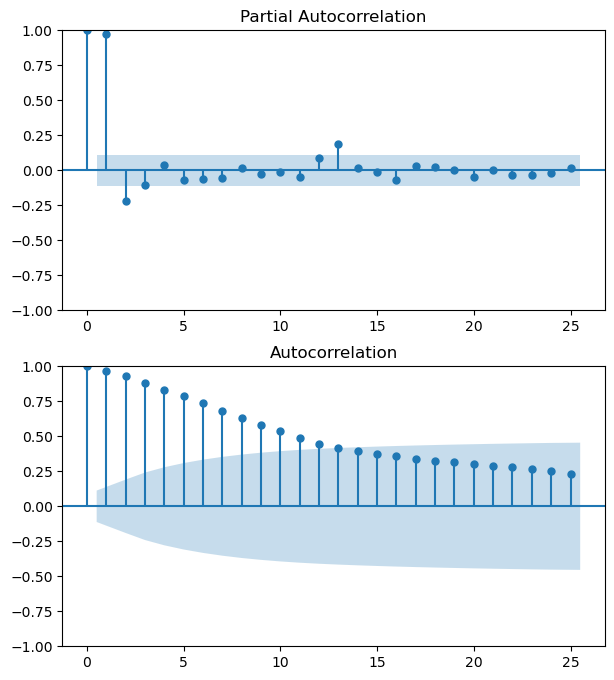

In [14]:
# plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(7,8))
ax1 = fig.add_subplot(2,1,1)
fig = plot_pacf(df, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_acf(df, ax=ax2)
plt.show()

**From PACF graph** we can determine <code>p</code> is equal 2. The PACF plot shows the partial correlation coefficients between each observation and its lagged values while considering the influence of other observations. The significant spikes or "peaks" in the PACF plot indicate the number of significant AR terms. We will accept <code>p</code> as 1.

To determine 'p' from the PACF graph, look for the first lag (lag 1) where the PACF value is significant (outside the confidence interval) and subsequently drops to non-significant values. This drop-off point in the PACF plot corresponds to the optimal value of <code>p</code>. Any significant spikes beyond this drop-off point can be ignored.

**From ACF graph** we can determine <code>q</code> order. The autocorrelations are significant for a large number of lags. Perhaps the autocorrelations at lags 2 and above are merely due to the propagation of the autocorrelation at lag 1, which is confirmed by the PACF plot. 

To determine <code>q</code> from the ACF graph, look for the first lag (lag 1) where the ACF value is significant (outside the confidence interval) and subsequently decreases to non-significant values. This decrease point in the ACF plot corresponds to the optimal value of <code>q</code>. Any significant spikes beyond this decrease point can be disregarded. We will accept <code>q</code> as 1.

# 5 Auto ARIMA Function

Auto ARIMA is a convenient tool that automates the process of finding the optimal ARIMA model and determining the values for the three parameters **(p, d, q)** in a systematic manner. It utilizes a stepwise approach, exploring various combinations of **(p, d, q)** terms, and selects the model with the lowest Akaike Information Criterion (AIC) as the best fit. 

In this step we will check and compare with our choice. 

In [15]:
from pmdarima import auto_arima

In [16]:
stepwise_fit = auto_arima(df['Rate'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=401.223, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=494.671, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=467.174, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=420.037, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=399.517, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=399.454, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=399.991, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=397.861, Time=0.19 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=399.667, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=440.567, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.762 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  304
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -195.931
Date:                Fri, 09 Jun 2023   AIC                            397.861
Time:                        21:45:30   BIC                            408.992
Sample:                    01-31-1998   HQIC                           402.315
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3807      0.051      7.482      0.000       0.281       0.480
ma.L1         -0.9815      0.010    -99.090      0.000      -1.001      -0.962
sigma2         0.2125      0.011     18.743      0.000       0.190       0.235
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               384.62
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.41
Prob(H) (two-sided):                  0.47   Kurtosis:                         8.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The function suggests **(p = 1, d = 2 q = 1)** to be the best order, while our choice was **(p = 1, d = 1 or 2, q = 1)**.

We will go with **(p = 1, d = 2 q = 1)**.

# 6 Developing the ARIMA Model


In [17]:
# p=1, d=2, q=1
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df['Rate'], order=(1,2,1), freq='M')
model_fit = model.fit()
model_fit.summary()

/Users/denys_storozhuk/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                  304
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -195.931
Date:                Fri, 09 Jun 2023   AIC                            397.861
Time:                        21:45:30   BIC                            408.992
Sample:                    01-31-1998   HQIC                           402.315
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3807      0.051      7.482      0.000       0.281       0.480
ma.L1         -0.9815      0.010    -99.090      0.000      -1.001      -0.962
sigma2         0.2125      0.011     18.743      0.000       0.190       0.235
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               384.62
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.41
Prob(H) (two-sided):                  0.47   Kurtosis:                         8.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# predict values
pred = model_fit.predict(start=0, end=len(df) - 1, typ='levels', dynamic=False)

In [19]:
# display last rows
pred.tail()

2022-12-31    16.115842
2023-01-31    15.110376
2023-02-28    16.258030
2023-03-31    17.841979
2023-04-30    14.536638
Freq: M, Name: predicted_mean, dtype: float64

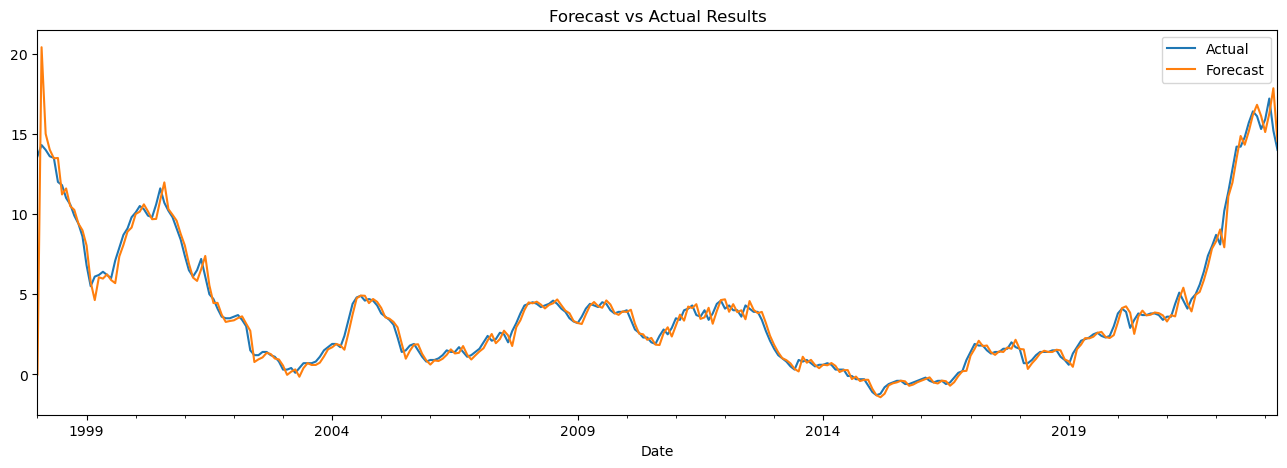

In [20]:
# plot results
df['Rate'].plot(legend=True, label='Actual', figsize=(16,5))
pred.plot(legend=True, label='Forecast')
plt.title('Forecast vs Actual Results')
plt.show()

# 7 Accuracy Metrics and Measure Performance of Fitted Model

We will plot diagnostics and calculate some accuracy metrics to judge the performance of our model.

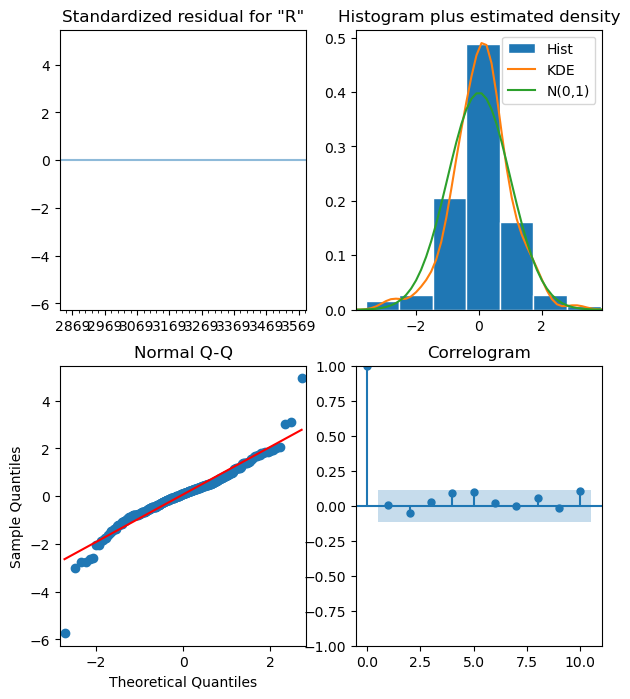

In [21]:
# diagnostic plots for standardized residuals of one endogenous variable
model_fit.plot_diagnostics(figsize=(7,8))
plt.show()

**Standardized residual for "R":** standardized residual for "R" over time equals 0, so we can assume that it suggests that the residuals have zero mean and are centered around the horizontal zero line. This is generally considered a desirable characteristic in a well-fitted model. A standardized residual is the residual value divided by its standard deviation, so a value of 0 indicates that the residual is exactly at the expected value based on the model. It implies that the model has effectively captured the patterns and variations in the data, and the residuals are not biased.

**Histohram plus estimated density:** The density plot in the model diagnostics suggests that the residuals follow a normal distribution centered around zero. This indicates that the residuals have a symmetric distribution and align well with the assumptions of the model.

**Normal Q-Q plot:** Ideally, in the diagnostic plot, all the markers representing the residuals should align perfectly on the red line. This indicates that the residuals are normally distributed with a mean of zero. However, if there are significant deviations observed, such as markers deviating from the red line or the presence of a skewed pattern, it suggests that the distribution of residuals is not perfectly symmetric and may exhibit skewness.

**Correlogram plot:** The correlogram, also known as the autocorrelation plot, displays the correlation between the residual errors at different lag intervals. If the correlogram shows that the residual errors are not autocorrelated, it indicates that there is no significant correlation or pattern remaining in the residuals that is not accounted for by the model.

Overall, these diagnostic figures indicate a well-fitted model with no significant anomalies.

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
rmse = mean_squared_error(pred, df['Rate'], squared=False)
rmse

0.9725645841212008

The root mean squared error (RMSE) value of 0.9725 indicates the average magnitude of the prediction errors of the model.

In [24]:
from sklearn.metrics import mean_absolute_error

In [25]:
mae = mean_absolute_error(pred, df['Rate'])
mae

0.39078566988588925

The mean absolute error (MAE) value of 0.3908 indicates the average absolute difference between the predictions of your model and the actual values. In other words, on average, the predictions differ from the actual values by approximately 0.3908 units.

In [26]:
mape = np.mean(np.abs(df['Rate'] - pred) / df['Rate']) * 100
mape

9.718271104585655

The mean absolute percentage error (MAPE) value of 9.7183 indicates the average percentage difference between the predictions of your model and the actual values. In other words, on average, the predictions differ from the actual values by approximately 9.7183% of the actual values.

In [27]:
corr = np.corrcoef(pred, df['Rate'])[0,1]
corr

0.969142451382577

In this case, a correlation coefficient of 0.9691 suggests a strong positive linear relationship between the predictions and the actual values. It indicates that the model's predictions are highly aligned with the actual values, and as one variable increases, the other variable tends to increase as well.

# 8 Extrapolating Future Inflation Data

We will forecast future inflation rates for the coming months (actually we are interested in result for May).

In [28]:
# predict values
forecast = model_fit.predict(start=0, end=len(df) + 4, typ='levels', dynamic=False)

In [31]:
# display forecasted values
forecast.tail(9)

2023-01-31    15.110376
2023-02-28    16.258030
2023-03-31    17.841979
2023-04-30    14.536638
2023-05-31    13.631309
2023-06-30    13.579138
2023-07-31    13.647480
2023-08-31    13.761708
2023-09-30    13.893406
Freq: M, Name: predicted_mean, dtype: float64

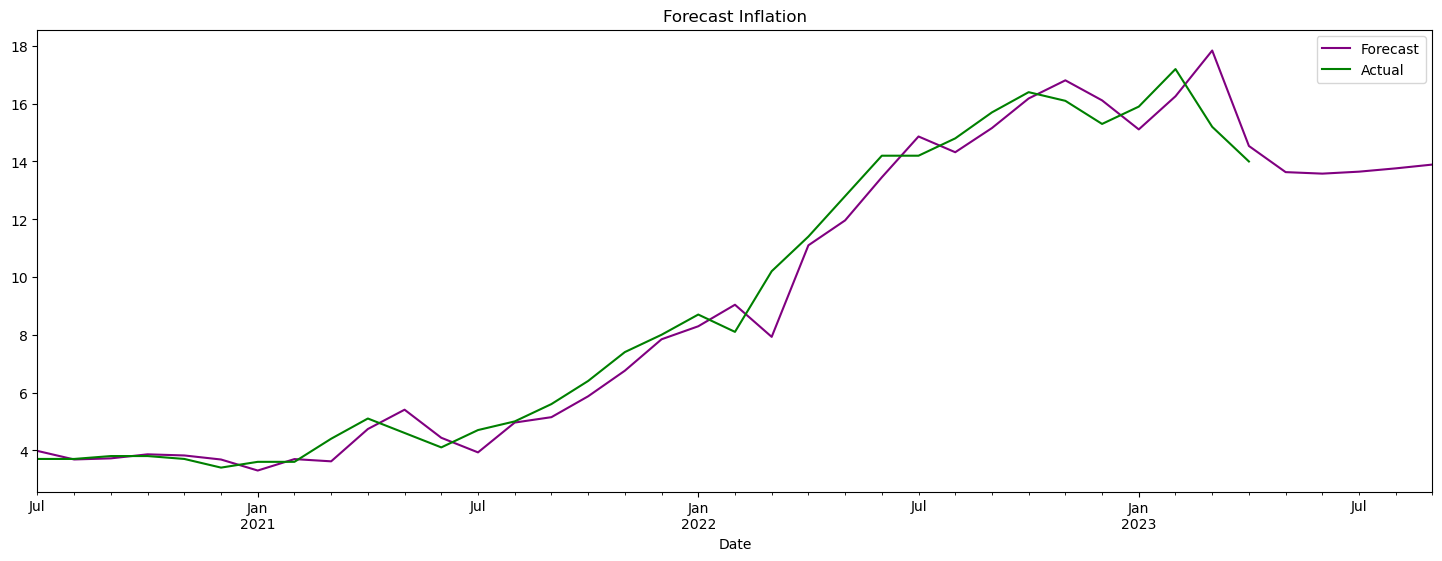

In [30]:
# final plot
forecast.iloc[270:].plot(legend=True, label='Forecast', figsize=(18,6), color='purple')
df['Rate'].iloc[270:].plot(legend=True, label='Actual', color='green')
plt.title('Forecast Inflation')
plt.show()

### Conclusions

We forecasted inflation rates by developing a machine learning algorithm. As accepted, inflation in Poland will continue to decrease and for May it will have 13,63%.